In [1]:
import tensorflow as tf
import keras



Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8645891680405088204
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16073571077437798775
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7000102027655140843
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5403499405147449980
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005


def initial_conv(input):
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.common.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.common.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.common.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, W_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":
    from keras.utils import plot_model
    from keras.layers import Input
    from keras.models import Model

    init = (68, 100,1)

    wrn_28_10 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.0)

    wrn_28_10.summary()

   # plot_model(wrn_28_10, "WRN-16-2.png", show_shapes=True, show_layer_names=True)


Wide Residual Network-16-2 created.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 100, 16)  144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 68, 100, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 68, 100, 16)  0           batch_normalization_1[0][0]      
________________________________________________________

## Train

In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np


In [5]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_data_X, Y_data, test_size=0.33, random_state=42)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
# creating initial dataframe

y_train_df = pd.DataFrame(y_train, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_train_df['New'] = labelencoder.fit_transform(y_train_df['Label'])
y_test_df = pd.DataFrame(y_test, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_test_df['New'] = labelencoder.fit_transform(y_test_df['Label'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils

In [0]:
EPOCHS = 100
BS = 128
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")

In [0]:
img_rows, img_cols = X_train[0].shape


# transform data set
if K.common.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [0]:

from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD
def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.2
  epochs_drop = 60
  lrate = 0.1
  if math.floor((1+epoch)/epochs_drop) !=0:
    lrate = initial_lrate*math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate
 
sgd = SGD(lr=0.1, momentum=0.9)

In [13]:
wrn_28_10.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")


Finished compiling


In [14]:
from keras.utils import to_categorical

# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
hist = wrn_28_10.fit(X_train, to_categorical(y_train_df['New']), validation_split=0.33, epochs=EPOCHS, batch_size=BS, verbose=2, callbacks=callbacks_list)

2568/2568 [==============================] - 24s 9ms/step - loss: 2.4853 - acc: 0.3326 - val_loss: 2.5886 - val_acc: 0.2751
Epoch 2/200
2568/2568 [==============================] - 18s 7ms/step - loss: 2.3577 - acc: 0.3898 - val_loss: 2.4395 - val_acc: 0.3462
Epoch 3/200
2568/2568 [==============================] - 18s 7ms/step - loss: 2.2977 - acc: 0.4073 - val_loss: 2.2589 - val_acc: 0.4229
Epoch 4/200
2568/2568 [==============================] - 18s 7ms/step - loss: 2.2581 - acc: 0.4143 - val_loss: 2.2949 - val_acc: 0.4174
Epoch 5/200
2568/2568 [==============================] - 18s 7ms/step - loss: 2.1728 - acc: 0.4330 - val_loss: 2.1829 - val_acc: 0.4245
Epoch 6/200
2568/2568 [==============================] - 18s 7ms/step - loss: 2.0995 - acc: 0.4529 - val_loss: 2.2563 - val_acc: 0.4134
Epoch 7/200
2568/2568 [==============================] - 18s 7ms/step - loss: 2.0170 - acc: 0.4891 - val_loss: 2.0742 - val_acc: 0.4664
Epoch 8/200
2568/2568 [==============================] - 18s

In [0]:
from keras.utils import to_categorical
#wrn_28_10.fit_generator(aug.flow(X_train, to_categorical(y_train_df['New']), batch_size=BS),validation_data=(X_test, to_categorical(y_test_df['New'])), validation_steps=X_test.shape[0] // BS,)

In [16]:
import keras.utils.np_utils as kutils
yPreds = wrn_28_10.predict(X_test)
yPred = np.argmax(yPreds, axis=1)
yPred[0]

3

In [17]:
yPred[2]

1

In [18]:
yTrue = y_test_df['New']
yTrue[2]

1

In [19]:
yPreds

array([[3.25724576e-03, 1.69853563e-03, 6.39387453e-03, 9.88650441e-01],
       [4.32612467e-07, 9.99977827e-01, 2.16743283e-05, 1.26896493e-08],
       [4.58722860e-01, 5.26561975e-01, 1.02345766e-02, 4.48056357e-03],
       ...,
       [1.05931445e-13, 1.57635766e-10, 1.00000000e+00, 2.27572058e-10],
       [4.43276912e-02, 3.64337802e-01, 5.68621099e-01, 2.27134004e-02],
       [1.48276554e-03, 1.05738651e-03, 9.97195363e-01, 2.64485716e-04]],
      dtype=float32)

In [28]:
import sklearn.metrics as metrics


accuracy = metrics.accuracy_score(yTrue, yPred) * 100
error = 100 - accuracy
print("Accuracy : ", accuracy)
print("Error : ", error)

Accuracy :  66.49020645844362
Error :  33.50979354155638


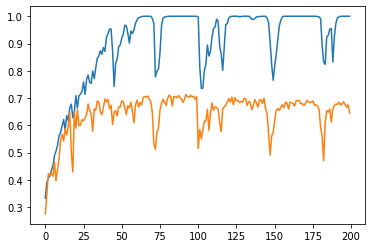

In [27]:
from matplotlib import  pyplot


pyplot.plot(hist.history["acc"], label='train')
pyplot.plot(hist.history['val_acc'], label='test')



In [22]:
hist.history['loss']


[2.4852685898635247,
 2.3577441656700917,
 2.2976779514384047,
 2.2581057058316527,
 2.172838179121879,
 2.0995072338068597,
 2.016986147265568,
 1.9700154433740633,
 1.9203159051520802,
 1.8420374044376742,
 1.7620685821010316,
 1.7019386336068127,
 1.633372816341317,
 1.667760568987172,
 1.54664027059561,
 1.5650473420865068,
 1.4599247951745244,
 1.3653090003866273,
 1.5064145014664838,
 1.4436111754717484,
 1.3039106955038053,
 1.35924953537938,
 1.2641059732140039,
 1.2399832572892449,
 1.1787623495699089,
 1.1082134391659888,
 1.1696957535461474,
 1.0750275664611768,
 1.0041106716494694,
 1.0599869341122399,
 1.049710791244685,
 0.941314704692995,
 0.9953079357325474,
 0.8966918051057144,
 0.8146872180644597,
 0.7754658206229641,
 0.7372594061670273,
 0.7532974366458406,
 0.6837602549252851,
 0.7208685266823041,
 0.5981945119728552,
 0.552755093184587,
 0.49170571807017577,
 0.4938759761064595,
 0.6820475323549312,
 1.0600451145588052,
 0.8172963107486381,
 0.7703278302403626,
 0